This notebook is used to calculate the differential abundance of OTUs in soils with PyOM or stover additions, as compared to soil only plots

In [2]:
%load_ext rpy2.ipython
# extension for using R cell magic in python

In [4]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(doParallel)
library(RColorBrewer)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

In [6]:
%%R
#Creating the physeq object from our tree and biom table with taxonimic and metadata already included, telling it \
# that the taxonomy is from greengenes database, so it will recognize the samples
physeq = import_biom("../data/otu_table_tax_no211_meta.biom", 
                     parseFunction=parse_taxonomy_greengenes)
# combines the otu table and the mapping file

sample.data = sample_data(physeq)

In [23]:
%%R
#run deseq on each subset of factors (day and amendment), return the factors, OTU ID, base mean, log2-fold change, 
# the standard error, and the p value associated with the response.

Dif_Abund = function(Amdmt, Day){
    physeq.pruned <- prune_samples((sample.data$Day == Day)& ((sample.data$Amdmt == Amdmt) | (sample.data$Amdmt == 0)), physeq)
    dseq = phyloseq_to_deseq2(physeq.pruned, ~Amdmt)
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    taxonomy = data.frame(tax_table(physeq.pruned))
    results = results(dseq)
    results$Day = Day
    results$Amdmt = Amdmt
    results = data.frame(results$Day,results$Amdmt,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy)
    colnames(results)[1:7] = c("Day","Amdmt","OTU","baseMean","l2FC","SE","pvalue")
    results
    }

In [11]:
%%R
# Creating a matrix with the different combinations of variables for day and amendment
variables = expand.grid(Amdmt = c("1", "2"),
                        Day = c(1, 2))
variables

  Amdmt Day
1     1   1
2     2   1
3     1   2
4     2   2


In [24]:
%%R
# Joining the variables and the differential abundance
DA<-mdply(variables,Dif_Abund)
# Runs the  differential abundance function we created above on all the combinations of variables

converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode


In [25]:
%%R
head(DA)

  Day Amdmt     OTU   baseMean        l2FC         SE    pvalue  Kingdom
1   1     1  OTU.43  223.48048 -0.11012779 0.29052924 0.7046439 Bacteria
2   1     1   OTU.2 1664.01427  0.11095267 0.07837381 0.1568676 Bacteria
3   1     1 OTU.187  362.13258  0.06605159 0.15991481 0.6795756 Bacteria
4   1     1 OTU.150   39.05672  0.03205671 0.15816953 0.8393906 Bacteria
5   1     1  OTU.91   62.21140 -0.01718316 0.37497442 0.9634498 Bacteria
6   1     1 OTU.305   37.70726 -0.14629517 0.27103038 0.5893528 Bacteria
          Phylum               Class            Order            Family
1    Nitrospirae          Nitrospira    Nitrospirales    Nitrospiraceae
2 Proteobacteria Alphaproteobacteria      Rhizobiales Bradyrhizobiaceae
3  Acidobacteria      Acidobacteriia Acidobacteriales   Koribacteraceae
4 Proteobacteria Alphaproteobacteria Rhodospirillales  Acetobacteraceae
5  Bacteroidetes      Flavobacteriia Flavobacteriales   [Weeksellaceae]
6    Chloroflexi      Thermomicrobia     JG30-KF-CM45    

In order to cut down the number of samples that we even consider for significant differences, we filter out those samples that we can predict ahead of time likely won't be significant.
Then, when we adjust p values for the multiple comparisons we are making, we won't "waste" our adjustments on samples that we knew ahead of time wouldn't likely be significant.
One good predictor of whether we'll get significant results is whether the OTUs have high counts (or relative abundances). If we only have a couple of "sightings" of a given OTU, it will be unlikely we will have the statistical power to have confidence.

In [26]:
%%R
threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(cutoff=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}
# Takes our table of differential abundance values,
# and determines those for which the baseMean values is greater or equal to whatever we input as threshould
# Then, for any samples that meet that criterion, we add a column (mutate), where we adjust the p value 
# using the Benjamini & Hochberg correction
# Then we summarize the results, listiing the cutoff threshold, and then the total number of OTUs for which the 
# new adjusted p values is less than 0.10 (just a standard level used by others).
# Note we also specify that the functions are called using dplyr package ("dplyr::").

In [27]:
%%R
range = seq(0,1,0.1)
# Creates a range of numbers we are interested in for adjusted p values

In [28]:
%%R
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

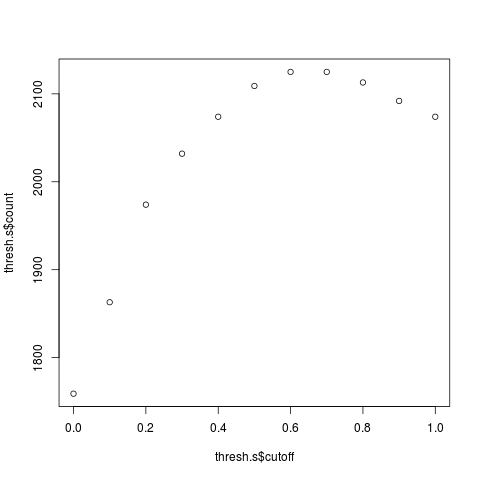

In [29]:
%%R
plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 0.6)

In [30]:
%%R
filter(DA,baseMean>=0.6) %>% mutate(padj = p.adjust(pvalue,"BH")) %>% write.csv("../data/l2fc.csv", row.names=FALSE)
# We take that differential abundance table we created above, and filter it to include only those samples 
# that had a baseMean value above the optimal cutoff we determined above.
# We then adjust the p values and save it as a csv.

In [31]:
!head ../data/l2fc.csv | cut -c 1-80

"Day","Amdmt","OTU","baseMean","l2FC","SE","pvalue","Kingdom","Phylum","Class","
1,"1","OTU.43",223.480476760568,-0.110127792559516,0.290529241717165,0.704643875
1,"1","OTU.2",1664.01427323273,0.110952667246641,0.0783738103853471,0.1568676044
1,"1","OTU.187",362.132576964478,0.0660515941822755,0.159914812466415,0.67957556
1,"1","OTU.150",39.0567230436438,0.0320567063241244,0.158169528121542,0.83939056
1,"1","OTU.91",62.2114018390707,-0.0171831613331207,0.374974418838079,0.96344982
1,"1","OTU.305",37.7072580260407,-0.146295170832724,0.271030375040768,0.58935284
1,"1","OTU.25",187.19887275687,0.0945287904788471,0.241875397098751,0.6959332006
1,"1","OTU.4258",216.80811533347,-0.0986802477067795,0.111800295183156,0.3774267
1,"1","OTU.453",49.5655884056922,-0.172410725872039,0.1511126220515,0.2538940912


In [68]:
%%R
d = read.csv("../data/l2fc.csv")

In [74]:
%%R
max.l2fc = d %>%
            group_by(Phylum)%>%
            summarize(M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
POrder = max.l2fc[with(max.l2fc, order(-M)),]$Phylum
POrder

[1] Proteobacteria  Bacteroidetes   Actinobacteria  Verrucomicrobia
[5] Planctomycetes  Acidobacteria  
6 Levels: Acidobacteria Actinobacteria Bacteroidetes ... Verrucomicrobia


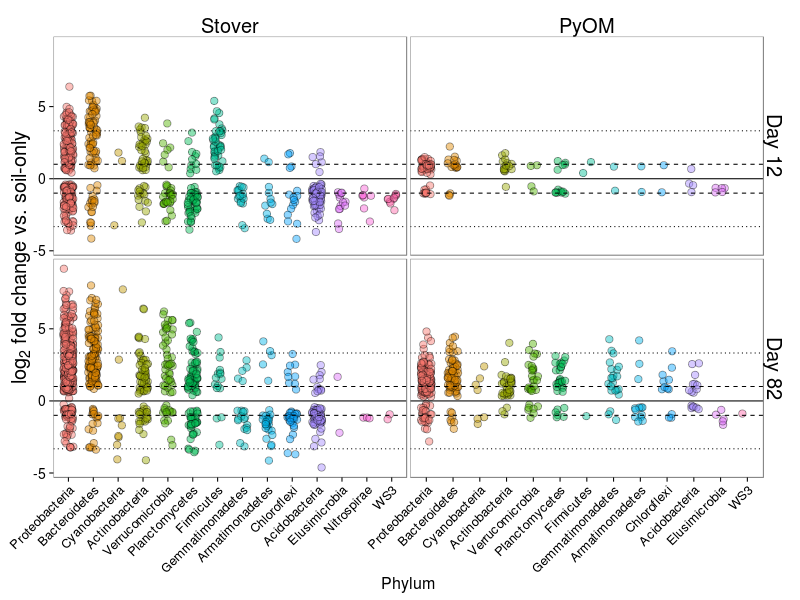

In [105]:
%%R -w 800 -h 600
# setting the image sizes, then making the figure...

d = read.csv("../data/l2fc.csv")

d = d %>%
    filter(padj<=0.1)

d$Phylum = substr(as.character(d$Phylum),0,nchar(as.character(d$Phylum)))
# makes the Phylum column of our d table a character.

d$Phylum[is.na(d$Phylum)] <- "Unclassified"
# if there is an NA in the Rank2 column, then it gets called "unclassified"

d$Phylum = factor(d$Phylum)
# Establishes that Rank2 is a factor.

levels(d$Phylum)[levels(d$Phylum) == "[Thermi]"] <- "Thermi"
levels(d$Phylum)[levels(d$Phylum) == ""] <- "Unclassified"
levels(d$Phylum)[levels(d$Phylum) == "NA"] <- "Unclassified"
# Fixes two phylum labelling issues

N=7
Phyla = levels(d$Phylum)

NPhylum <- function (x){
    m = c()
    for (i in x){
       L <- length(d$Phylum[d$Phylum==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NPhylum(Phyla))
d<-d[d$Phylum %in% Include,]
d$Phylum<-factor(d$Phylum)

    
max.l2fc = d %>%
            group_by(Phylum)%>%
            summarize(M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
POrder = max.l2fc[with(max.l2fc, order(-M)),]$Phylum

d$Phylum = factor(d$Phylum,levels=POrder)
# takes our phylum column, and arranges it in order of our log2FoldChange values    


d$DayName = ifelse(d$Day==1,"Day 12","Day 82")
d$strip1 = paste(d$DayName)
d$AmdmtName = ifelse(d$Amdmt==1,"PyOM","Stover")
d$AmdmtName <- factor(d$AmdmtName, levels = c("Stover","PyOM"))
d$strip2 = paste(d$AmdmtName)
# Creates a "strip" column of d with either Day or Amendment

M = max(as.numeric(d$Phylum), na.rm = TRUE) + 1
d$x = as.numeric(d$Phylum)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.25

p = ggplot(d, aes(x = Phylum, y = l2FC, fill = Phylum))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_grid(~DayName~AmdmtName, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

p = p + geom_point(shape = 21, size = 3.5, alpha=0.45, position = position_jitter(w = 0.20))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 13, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 16),
              axis.text.y = element_text(size=14),
              axis.title.y = element_text(size = 20),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Phylum")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil-only",sep="")))
# sets the label for the y axes.

p = p + scale_fill_discrete(guide="none")

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

In [106]:
%%R
ggsave(filename = "4xLog2.pdf", plot = p, width=8, height = 6.5)

In [36]:
%%R

d = read.csv("../data/l2fc.csv")

d = d %>%
    filter(padj<=0.1) %>%
    filter(Phylum=="Acidobacteria")


d$Tax = d$Class
d$SubG = ifelse ((d$Tax == "Acidobacteria-6" | d$Tax == "iii1-8"), "Subgroup 6",
                     ifelse((d$Tax == "[Chloracidobacteria]"), "Subgroup 4",
                            ifelse((d$Tax == "Acidobacteria-5"), "Subgroup 5",
                                   ifelse((d$Tax == "Solibacteres"), "Subgroup 3",""))))
d$Tax = d$SubG
levels(as.factor(d$SubG))

[1] ""           "Subgroup 3" "Subgroup 4" "Subgroup 5" "Subgroup 6"


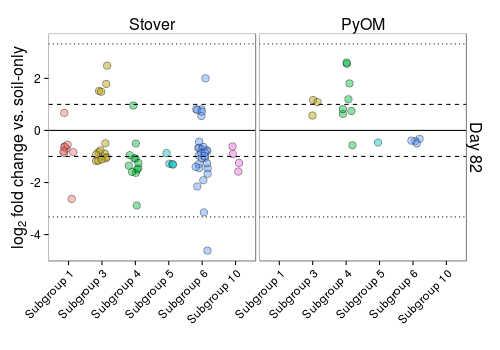

In [55]:
%%R -w 500 -h 350
# setting the image sizes, then making the figure...


d = read.csv("../data/l2fc.csv")

d = d %>%
    filter(padj<=0.1) %>%
    filter(Phylum=="Acidobacteria") %>%
    filter(Day == 2)


d$Tax = d$Class
d$SubG = ifelse ((d$Tax == "Acidobacteria-6" | d$Tax == "iii1-8"), "Subgroup 6",
                     ifelse((d$Tax == "[Chloracidobacteria]"), "Subgroup 4",
                        ifelse((d$Tax == "Acidobacteria-5"), "Subgroup 5",
                            ifelse((d$Tax == "Acidobacteriia"), "Subgroup 1",
                               ifelse((d$Tax == "Sva0725"), "Subgroup 10",
                                   ifelse((d$Tax == "Solibacteres"), "Subgroup 3",paste(d$Tax)))))))
d$SubG = as.factor(d$SubG)
#d$Tax = d$SubG

N=3
Taxes = levels(d$SubG)

NTax <- function (x){
    m = c()
    for (i in x){
       L <- length(d$SubG[d$SubG==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NTax(Taxes))
d<-d[d$SubG %in% Include,]
d$SubG<-factor(d$SubG)

    
#max.l2fc = d %>%
#            group_by(SubG)%>%
#            summarize(M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
PTax = c("Subgroup 1", "Subgroup 3", "Subgroup 4", "Subgroup 5", "Subgroup 6", "Subgroup 10")

d$SubG = factor(d$SubG,levels=PTax)
# takes our phylum column, and arranges it in order of our log2FoldChange values    


d$DayName = ifelse(d$Day==1,"Day 12","Day 82")
d$strip1 = paste(d$DayName)
d$AmdmtName = ifelse(d$Amdmt==1,"PyOM","Stover")
d$AmdmtName <- factor(d$AmdmtName, levels = c("Stover","PyOM"))
d$strip2 = paste(d$AmdmtName)
# Creates a "strip" column of d with either Day or Amendment

M = max(as.numeric(d$SubG), na.rm = TRUE) + 1
d$x = as.numeric(d$SubG)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.25

p = ggplot(d, aes(x = SubG, y = l2FC, fill = SubG))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_grid(~DayName~AmdmtName)
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

p = p + geom_point(shape = 21, size = 3.5, alpha=0.45, position = position_jitter(w = 0.20))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 16),
              strip.text.y = element_text(size = 16),
              axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 14),
              axis.text.y = element_text(size=12),
              axis.title.y = element_text(size = 16),
              legend.title = element_text(size=16),
              legend.text = element_text(size = 12),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil-only",sep="")))
# sets the label for the y axes.

p = p + scale_fill_discrete(guide="none")

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

In [56]:
%%R
ggsave(filename = "AcidoLog2.pdf", plot = p, width=5, height = 5)